# MLP Model

In [4]:
import pandas as pd
import numpy as np
import sagemaker
import os
from utils import standardize_data
from sagemaker import LinearLearner
from sagemaker import get_execution_role

# specify an output path
prefix = 'wildfire'
data_dir = 'wildfire_data'
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
output_path = 's3://{}/{}'.format(bucket, prefix)
role = get_execution_role()

In [5]:
from sagemaker.sklearn.estimator import SKLearn

sklearn_mlp = SKLearn(entry_point='train_mlp.py', 
                 source_dir='source_sklearn',
                 role=role,
                 train_instance_count=1,
                 train_instance_type='ml.c4.xlarge',
                 sagemaker_session=sagemaker_session,
                 py_version='py3',
                 framework_version='0.23-1')

train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [6]:
%%time
output_path='s3://{}/{}/'.format(bucket, prefix)

# Train your estimator on S3 training data
sklearn_mlp.fit({'train': output_path})

2021-02-07 05:50:43 Starting - Starting the training job...
2021-02-07 05:50:47 Starting - Launching requested ML instancesProfilerReport-1612677043: InProgress
......
2021-02-07 05:51:57 Starting - Preparing the instances for training......
2021-02-07 05:53:03 Downloading - Downloading input data...
2021-02-07 05:53:44 Training - Training image download completed. Training in progress..2021-02-07 05:53:34,815 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2021-02-07 05:53:34,817 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-02-07 05:53:34,826 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-02-07 05:53:35,147 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-02-07 05:53:35,814 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-02-07 05:53:35,827 sagemaker-training-toolkit INFO     No GPUs detected (

In [7]:
mlp_predictor = sklearn_mlp.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

-----------------!

In [8]:
test_x = pd.read_csv(os.path.join(data_dir, 'test.csv'), header=None)
test_y = pd.read_csv(os.path.join(data_dir, 'test_y.csv'), header=None)

In [9]:
prediction_batches = [mlp_predictor.predict(batch) for batch in np.array_split(test_x, 100)]

In [10]:
prediction_batches[0]

array([0, 0, 0, ..., 4, 0, 8])

In [11]:
test_y_preds = np.concatenate([batch for batch in prediction_batches])

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from utils import print_f1_scores
accuracy_mlp = accuracy_score(test_y, test_y_preds)
f1_score_mlp = f1_score(test_y, test_y_preds, average=None)
df_f1_score_mlp = print_f1_scores(f1_score_mlp)

In [13]:
accuracy_mlp

0.3894401533517506

In [14]:
df_f1_score_mlp

,Causes Description,F1 scores
0,Lightning,0.589392
1,Equipment Use,0.035791
2,Smoking,0.000000
3,Campfire,0.082728
4,Debris Burning,0.519612
5,Railroad,0.000000
6,Arson,0.278129
7,Children,0.129730
8,Miscellaneous,0.391088
9,Fireworks,0.273736


In [12]:
mlp_predictor.delete_endpoint()

In [17]:
# sklearn_model = sagemaker.sklearn.model.SKLearnModel(
#     model_data = "s3://sagemaker-us-west-1-170667047098/sagemaker-scikit-learn-2021-02-07-05-50-43-359/output/model.tar.gz",
#     role = role,
#     entry_point='train_mlp.py', 
#     source_dir='source_sklearn',
#     py_version='py3',
#     framework_version='0.23-1'
# )

In [23]:
model_data_path = "s3://sagemaker-us-west-1-170667047098/sagemaker-scikit-learn-2021-02-07-05-50-43-359/output/model.tar.gz"
dest = "model.tar.gz"


In [36]:
import importlib
import get_model
importlib.reload(get_model)
from get_model import get_model_weights

loaded_mlp_model = get_model_weights(model_data_path, dest)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [37]:
from sklearn.metrics import plot_confusion_matrix

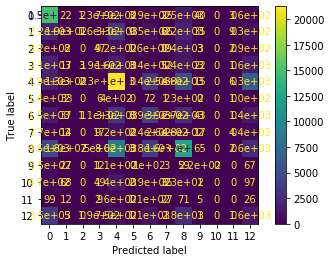

In [38]:
plot_confusion_matrix(loaded_mlp_model, test_x, test_y)